**Name:** Jingwei Kang <br>
**Date:** September 2018 <br>
**Reference:** "Effective stochastic dynamics on a protein folding energy landscape (Yang, Onuchic, Levine 2006)"

**Purpose:** <br>
The goal of this exercise is to determine drift and diffusion coefficients from simulation data through "equation-free computational methods", which can be used in modeling the kinetic behavior of systems over their free energy landscapes. More broadly, control theory can then be applied to modify temperature and navigate nanoparticles through this free energy landscape to self-assemble defect free crystals.<br>
Drift velocity is a measure of how quickly a system moves along the reaction coordinate as a result of thermodynamics. In comparison, diffusive motion is random and is needed to overcome thermodynamic energy barriers. With these two values across a range of reaction coordinates, the kinetics of a process can be better modeled through Langevin dynamics using the Fokker-Planck equation.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

**Toy Model:** <br>
As an example, we consider two-dimensional diffusion-drift dynamics on the free energy surface given by: <br>
$F(X,Y) = [(X^2-1)^2+(Y-1)^2][1+(Y+1)^2]$ <br>
Then: <br>
$\frac{dF}{dX} = 2(X^2-1)(2X)[1+(Y+1)^2]$ <br>
$\frac{dF}{dY} = 2X^4(Y+1)-4X^2(Y+1)+4Y^3$

Below, we plot the two-dimensional free energy surface. Note that the local minima at (X=-1, Y=1) and (X=1, Y=1) correspond to the "folded" and "unfolded" states, respectively.

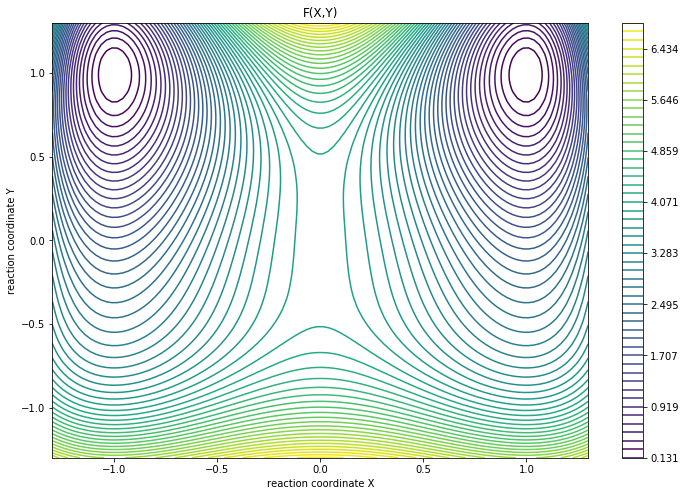

In [2]:
x = np.linspace(-1.3, 1.3, 100)
y = np.linspace(-1.3, 1.3, 100)
def F(x, y):
    '''
    Parameters:
    -----
    x: range of x
    y: range of y
    Returns:
    -----
    z: n by m matrix of values for F(X, Y) where n = len(x) and m = len(y)
    xv: meshgrid output for x
    yv: meshgrid output for y
    '''
    xv, yv = np.meshgrid(x,y)
    z = ((xv**2-1)**2+(yv-1)**2)*(1+(yv+1)**2)
    return z, xv, yv
z, xv, yv = F(x, y)
plt.figure(figsize=(12, 8))
plt.contour(xv, yv, z, levels=np.linspace(0,13,100))
plt.title('F(X,Y)')
plt.xlabel('reaction coordinate X')
plt.ylabel('reaction coordinate Y')
plt.colorbar();

The microscopic "Langevin" dynamics on the free surface are given by: <br>
$\frac{dX}{dt}=-\Gamma\frac{dF}{dX}+\eta$ <br>
$\frac{dY}{dt}=-\Gamma\frac{dF}{dY}+\eta$ <br>
The first term in the equations is the drift along the X or Y reaction coordinate, while the latter is a Gaussian white noise with homogeneous diffusion coefficient $<\eta(0)\eta(t)>=2D\delta t$. <br>
We let $\Gamma=1$ and $D=1$.

In [3]:
def dF_dX(x, y):
    z = 2*(x**2-1)*2*x*(1+(y+1)**2)
    return z
def dF_dY(x, y):
    z = 2*x**4*(y+1)-4*x**2*(y+1)+4*y**3
    return z

In [4]:
gamma = 1
D = 1
dt = np.float64(0.001)
n = np.int64(5*10**6)
def dX_dt(x, y):
    '''
    Parameters:
    -----
    x: range of x
    y: range of y
    Returns:
    -----
    dx_dt: drift + diffusion in x
    '''
    df_dx = dF_dX(x, y)
    dx_dt = -gamma*df_dx + np.random.normal(0, np.sqrt(2*D*dt))/dt
    return dx_dt
def dY_dt(x, y):
    '''
    Parameters:
    -----
    x: range of x
    y: range of y
    Returns:
    -----
    dy_dt: drift + diffusion in x
    '''
    df_dy = dF_dY(x, y)
    dy_dt = -gamma*df_dy + np.random.normal(0, np.sqrt(2*D*dt))/dt
    return dy_dt

**Approach:** <br>
We start in the unfolded state (X=1, Y=1) and simulate for $5*10^6$ time steps with step size of 0.001s. From this simulation data, we can then determine the drift and diffusion coefficients at a certain reaction coordinate by looking at how the reaction coordinate and variance of reaction coordinates change over time, respectively.

In [5]:
x_t = np.zeros([n, 1], dtype=np.float64)
y_t = np.zeros([n, 1], dtype=np.float64)
x_t[0] = 1
y_t[0] = 1
for i in np.arange(1, n):
    x_t[i] = x_t[i-1] + dX_dt(x_t[i-1], y_t[i-1])*dt
    y_t[i] = y_t[i-1] + dY_dt(x_t[i-1], y_t[i-1])*dt

We display how the reaction coordinates changes over $10^5$ time steps. Note that X tends to values around -1 and 1, which correspond to the local minima of folded and unfolded states, respectively. 

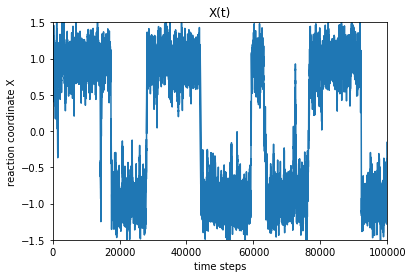

In [6]:
t = np.array(np.arange(0,n))
plt.plot(t, x_t)
plt.axis([0, 10**5, -1.5, 1.5])
plt.title('X(t)')
plt.xlabel('time steps')
plt.ylabel('reaction coordinate X');

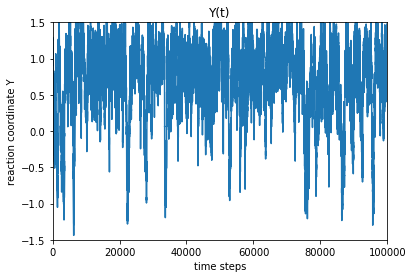

In [7]:
plt.plot(t, y_t)
plt.axis([0, 10**5, -1.5, 1.5])
plt.title('Y(t)')
plt.xlabel('time steps')
plt.ylabel('reaction coordinate Y');

To determine the local drift and diffusion coefficients, we need to aggregate data for when the system is around that specific reaction coordinate. We take a look at reaction coordinate X (which we refer to as Q moving forwards), as it describes the kinetics from folded to unfolded and vice versa. We look at Q in the range [-1.5, 1.5] to plot diffusion and drift coefficients as functions of the reaction coordinate. <br>

In [8]:
Qs = np.linspace(-1.5, 1.5, 31) # 0.1 is step size
dQ = 0.1 # Figure 5 of paper.

We determine the local drift and diffusion coefficients for a specific Q by aggregating all occurrences within a bin size $\delta Q=0.1$. We then take the mean and variances at these occurences, as well as for several timesteps thereafter. The drift coefficient is essentially the change in mean while the diffusion coefficient is the change in variance of the reaction coordinate, at the specific reaction coordinate. Assuming linearity:
$$
v(Q) = \frac{Q_c(t_2)-Q_c(t1)}{\Delta t} \\
D(Q) = \frac{\sigma^2(t_2)-\sigma^2(t_1)}{2\Delta t}
$$
However, since these slopes may be nonlinear with respect to time, we fit a quadratic model to the means and variances for a couple ensuing timesteps and then extrapolate the derivative to time 0.

In [9]:
def coeffs(Q):
    dQ = 0.1
    dt = 0.001
    t = np.arange(0, 0.006, 0.001)
    Q_star_t = [None] * 6 # stores 6 np.arrays indicating indices of t0, t1, ..., t5 where Q(t) = Q_star
    Q_star_avg_t = [None] * 6
    Q_star_var_t = [None] * 6
    Q_min = Q - dQ/2
    Q_max = Q + dQ/2
    Q_star_t[0] = np.where((x_t>Q_min)&(x_t<Q_max))[0]
    Q_star_avg_t[0] = np.mean(x_t[Q_star_t[0]])
    Q_star_var_t[0] = np.var(x_t[Q_star_t[0]])
    for i in np.arange(1, 6, 1):
        Q_star_t[i] = Q_star_t[i-1][Q_star_t[i-1]<(n-1)] + 1
        Q_star_avg_t[i] = np.mean(x_t[Q_star_t[i]])
        Q_star_var_t[i] = np.var(x_t[Q_star_t[i]])
    v_Q_lin = (Q_star_avg_t[2]-Q_star_avg_t[1])/dt
    v_Q = np.polyfit(t[2:6], Q_star_avg_t[2:6], 2)[1] 
    D_Q_lin = (Q_star_var_t[2]-Q_star_var_t[1])/(2*dt)
    D_Q = np.polyfit(t[2:6], Q_star_var_t[2:6], 2)[1]/2
    return (v_Q, D_Q)

Below we plot the drift and diffusion coefficients for a range of reaction coordinates. Note that the drift is close to 0 at -1.0, 0, and 1 which are local minima/maxima corresponding to the folded state, energy barrier, and unfolded state.

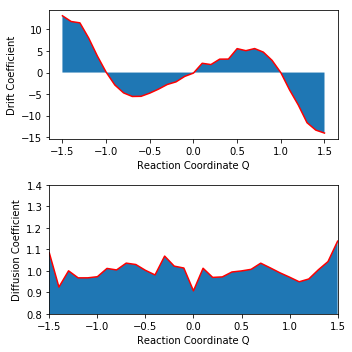

In [10]:
v_Qs = np.zeros_like(Qs)
D_Qs = np.zeros_like(Qs)
for i in np.arange(0, len(Qs)):
    v_Qs[i], D_Qs[i] = coeffs(Qs[i])

plt.figure(figsize=(5, 5))
plt.subplot(211)
plt.plot(Qs, v_Qs, 'r-')
plt.fill_between(Qs, v_Qs, np.zeros_like(Qs))
plt.xlabel('Reaction Coordinate Q')
plt.ylabel('Drift Coefficient')
plt.subplot(212)
plt.plot(Qs, D_Qs, 'r-')
plt.fill_between(Qs, D_Qs, np.zeros_like(Qs))
plt.xlabel('Reaction Coordinate Q')
plt.ylabel('Diffusion Coefficient')
plt.axis([-1.5, 1.5, 0.8, 1.4])
plt.tight_layout()

Plotting the distribution of the reaction coordinate after a number of time steps validates that drift and diffusive motion will shift and broaden the distribution of reaction coordinates.

In [11]:
def P(Q_t, Q, t):
    dQ = 0.1
    dt = 0.001
    index = int(t/dt)+1
    Q_min = Q - dQ/2
    Q_max = Q + dQ/2
    Q_star_t = [None] * index
    Q_star_t[0] = np.where((x_t>Q_min)&(x_t<Q_max))[0]
    # print(len(Q_star_t[0]))
    for i in np.arange(1, index, 1):
        Q_star_t[i] = Q_star_t[i-1][Q_star_t[i-1]<(n-1)] + 1
        # print(len(Q_star_t[i]))
    return Q_t[Q_star_t[index-1]]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


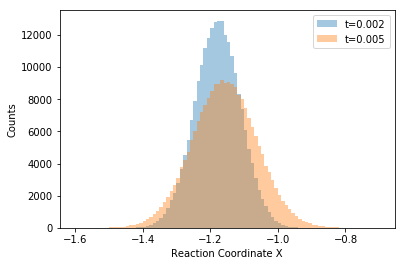

In [47]:
prob_t2 = P(x_t, -1.2, 0.002)
prob_t5 = P(x_t, -1.2, 0.005)
sns.distplot(prob_t2, label='t=0.002', kde=False, bins=np.arange(-1.6, -0.7, 0.01))
sns.distplot(prob_t5, label='t=0.005', kde=False, bins=np.arange(-1.6, -0.7, 0.01))
# sns.distplot(prob_t2, label='t=0.002')
# sns.distplot(prob_t5, label='t=0.005')
plt.xlabel('Reaction Coordinate X')
plt.ylabel('Counts')
plt.legend();

Using the Langevin equation to simulate the dynamics: <br>
$$
Q(t+\delta t) = Q(t) + v(Q)\delta t + \eta (Q)\sqrt{\delta t} \\
\eta = N(0,\sqrt{2D})
$$ 

Text(0,0.5,'Reaction Coordinate X')

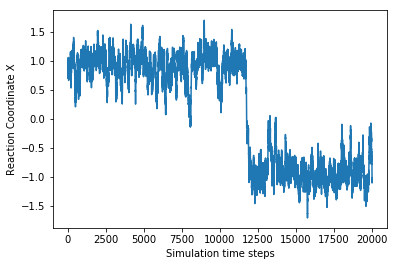

In [15]:
dt = np.float64(0.001)
t = np.arange(0, 2*10**4, 1)
langevin_Q = np.zeros_like(t, dtype = np.float64)
langevin_Q[0] = np.float64(1);
for i in t[1:]:
    v, D = coeffs(langevin_Q[i-1])
    langevin_Q[i] = langevin_Q[i-1] + v*dt + np.random.normal(0, np.sqrt(2*D))*np.sqrt(dt)
plt.plot(t, langevin_Q)
plt.xlabel('Simulation time steps')
plt.ylabel('Reaction Coordinate X')